In [27]:
from os.path import join
import time
import datetime

from random import sample, seed
from multiprocessing import cpu_count

import h5py

from pandas import read_csv, DataFrame, concat

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import f1_score

from tsfresh import extract_features
from tsfresh.feature_extraction import feature_calculators as fc
from tsfresh.feature_extraction.settings import MinimalFCParameters, EfficientFCParameters

print(f"Number of processor {cpu_count()}")

Number of processor 4


In [2]:
data_dir = "/home/benoit/data/dreem_challenge/"
data_path = "/home/benoit/data/dreem_challenge/X_train/X_train.h5"
labels_path = "/home/benoit/data/dreem_challenge/y_train.csv"

d = h5py.File(data_path, 'r')
labels = read_csv(labels_path)

print(d.keys())
labels.head()

<KeysViewHDF5 ['eeg_1', 'eeg_2', 'eeg_3', 'eeg_4', 'eeg_5', 'eeg_6', 'eeg_7', 'index', 'index_absolute', 'index_window', 'pulse', 'x', 'y', 'z']>


,index,sleep_stage
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [3]:
meta_data = DataFrame()

meta_data['index'] = d['index_absolute'][()]
meta_data['subject_id'] = d['index'][()]
meta_data['window'] = d['index_window'][()]
meta_data['label'] = labels['sleep_stage']

_N_ = len(meta_data)
_F_ = 50

meta_data.head()

,index,subject_id,window,label
0,0,0,0,0
1,1,0,1,0
2,2,0,2,0
3,3,0,3,0
4,4,0,4,0


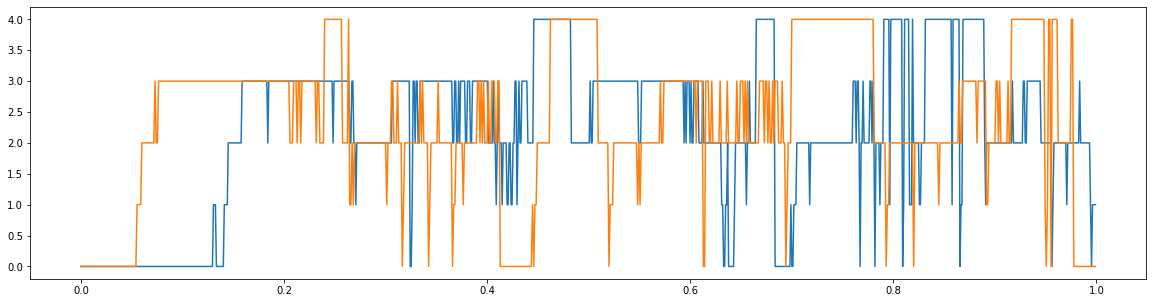

In [4]:
plt.rcParams['figure.figsize'] = [20, 5]

subject = meta_data[meta_data['subject_id'] == 0]
# Là j'ai normalisé les intervals temporels comme ils n'ont pas la même longueur 
plt.plot(subject['window'].values/len(subject['window'].values), subject['label'].values)
subject = meta_data[meta_data['subject_id'] == 1]
plt.plot(subject['window'].values/len(subject['window'].values), subject['label'].values)

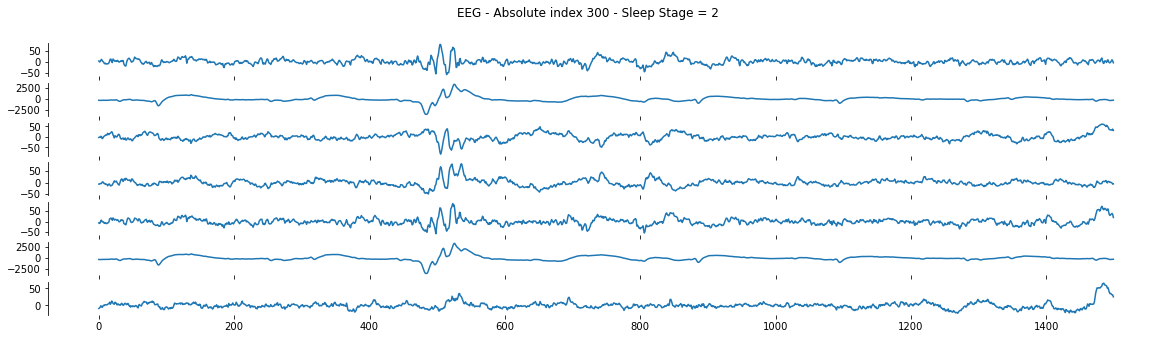

In [5]:
def plot_eeg(abs_index, raw_data, meta_data):
    plt.rcParams['figure.figsize'] = [20, 5]
    i = abs_index
    fig= plt.figure()
    fig.suptitle(f"EEG - Absolute index {i} - Sleep Stage = {meta_data['label'][i]}")
    for j in range(7):
        name = f"eeg_{j+1}"
        ax = fig.add_subplot(7, 1, j+1)
        for loc, spines in ax.spines.items():
            if not loc == 'left':
                spines.set_color('none')
        ax.plot(d[name][i])
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        ax.yaxis.set_ticks_position('left')
        
    ax.xaxis.set_ticks_position('bottom')
    plt.show()
    
for i in [300]:    
    plot_eeg(i, d, meta_data)

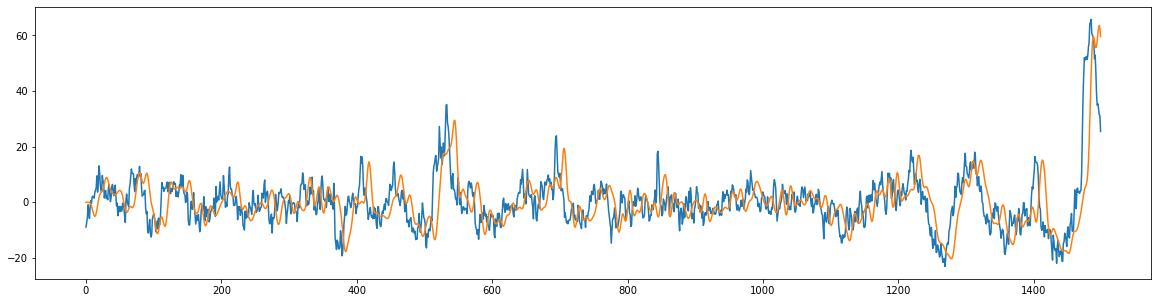

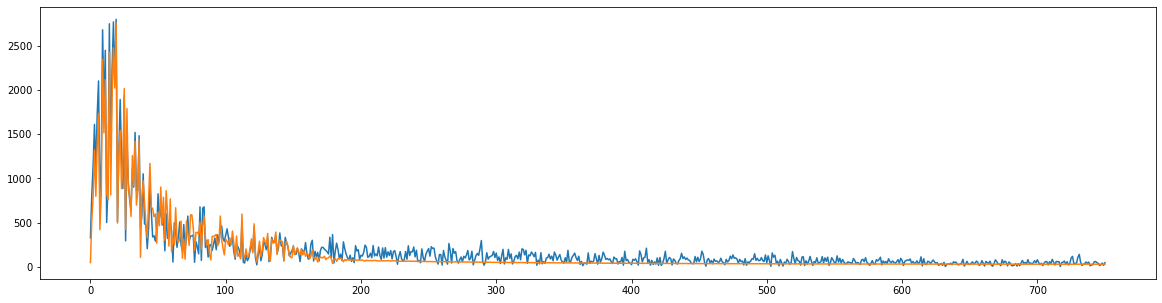

In [6]:
# Butterworth filter

from scipy import signal
sig = d['eeg_7'][300]
sos = signal.butter(10, 5, 'low', fs=_F_, output='sos')
filtered = signal.sosfilt(sos, sig)
plt.plot(sig)
plt.plot(filtered)
plt.show()

plt.plot(np.absolute(np.fft.rfft(sig)))
plt.plot(np.absolute(np.fft.rfft(filtered)))
plt.show()

In [7]:
# Etude des bandes de fréquence

def get_mean_freq_bands(x):
    
    fft_vals = np.absolute(np.fft.rfft(x))
    fft_freq = np.fft.rfftfreq(len(x), 1.0/_F_)

    eeg_bands = {'Delta': (0, 4),
                 'Theta': (4, 8),
                 'Alpha': (8, 12),
                 'Beta': (12, 30),
                 'Gamma': (30, 45)}

    # Take the mean of the fft amplitude for each EEG band
    eeg_band_fft = dict()
    for band in eeg_bands:  
        freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                           (fft_freq <= eeg_bands[band][1]))[0]
        
        if len(fft_vals[freq_ix]) == 0:
            mean = 0
        else:
            mean = np.mean(fft_vals[freq_ix])
        
        eeg_band_fft[band] = mean
        
    return eeg_band_fft

# TODO: Mettre en commun le calcul des bandes pour l'extraction de feature
def get_mean_alpha(x):
    return np.log(get_mean_freq_bands(x)['Alpha'])

def get_mean_beta(x):
    return np.log(get_mean_freq_bands(x)['Beta'])

def get_mean_delta(x):
    return np.log(get_mean_freq_bands(x)['Delta'])

def get_mean_theta(x):
    return np.log(get_mean_freq_bands(x)['Theta'])

def get_mean_gamma(x):
    return np.log(get_mean_freq_bands(x)['Gamma'])

In [8]:
# Etude de l'amplitude des singaux
def log_ampl(x):
    return np.log(max(abs(x)))

def log_mean(x):
    return np.log(np.mean(x))

def mean(x):
    return np.mean(x)

def log_energy(x):
    return np.log(fc.abs_energy(x))

def kurtosis(x):
    return fc.kurtosis(x)


def compare_prop(name, data, meta, spl, ax, func):
    eegs = data[name]
    prop = [0 for i in range(len(spl))]

    for j, i in enumerate(spl):
        prop[j] = func(eegs[i])
        
    res = DataFrame(columns=['feature', 'sleep_stage'])
    res['feature'] = prop
    res['sleep_stage'] = meta_data['label'].values[spl].astype(np.int)
    sns.boxplot(y='feature', x='sleep_stage', data=res, ax=ax)
    
def plot_compare_prop(func, data, meta, sample=None, ls_eeg=[1,2,3,4,5,6,7]): 
    #TODO: deal with samples same way as for exctract_features
    n = len(data['eeg_1'])
    n_samples = len(sample)
    
    spl = sample
    
    if spl is None:
        spl = [i for i in range(n)]

    fig, axes = plt.subplots(1, len(ls_eeg), sharey=True)
    plt.rcParams['figure.figsize'] = [20, 5]

    for i in ls_eeg:
        compare_prop(f"eeg_{i}", data, meta, spl, ax=axes[i-1], func=func)
        axes[i-1].set_title(f"EEG {i}")
        
        if not i == 0:
            axes[i-1].get_yaxis().set_visible(False)
    plt.show()

spl = sample([i for i in range(_N_)], 500)

# plot_compare_prop(get_mean_alpha, d, meta_data, sample=spl, ls_eeg=[1,2,3,4,5,6,7])

In [41]:
def extract_features(func, data, sample=None):
    n = len(data['eeg_1'])

    spl = sample
    
    if spl is None:
        spl = [i for i in range(n)]
        
    n_sample = len(spl)
        
    res = DataFrame(columns=[f"eeg_{i}_{f.__name__}" for i in range(7) for f in func])
    c=1
    for index in spl:
        t1 = time.time()
        print(f">>> {c} / {n_sample} <<<", end="\r")
        c+=1
        feat = [0 for i in range(len(func)*7)]
        
        for i, f in enumerate(func):
            for j in range(7):
                feat[len(func)*j+i] = f(data[f"eeg_{j+1}"][index])
                
        feat = dict(zip(res.columns, feat))
        res = res.append(feat, ignore_index=True)
        
        t2 = time.time()
        print(f">>> {c} / {n_sample} <<< (Remains : {str(datetime.timedelta(seconds=(t2 - t1)*(n_sample-c)))})", end="\r")
    return res

def extract_all_features(func, data, save):
    spl = [i for i in range(len(data['eeg_1']))]
    features = extract_features(func, data, sample=spl)
    features['abs_index'] = spl
    features.to_csv(save)
    
def load_features(path):
    features = read_csv(path)
    features = features.drop(['Unnamed: 0'], axis=1)
    return features

def merge_features(ls_features):
    for i in range(1, len(ls_features)):
        ls_features[i].drop(['abs_index'], axis=1)
        
    return concat(ls_features, axis=1)
    
    

#spl = sample([i for i in range(_N_)], 5000)

#features = extract_features([log_ampl, mean, log_energy, kurtosis], d, sample=spl)  
#y = meta_data["label"][spl]

In [54]:
features = load_features(join(data_dir, "computed", 'base_1_train.csv'))
y = meta_data['label']

features = features.drop(['abs_index'], axis=1)
features

,eeg_0_log_ampl,eeg_0_mean,eeg_0_log_energy,eeg_0_kurtosis,eeg_1_log_ampl,eeg_1_mean,eeg_1_log_energy,eeg_1_kurtosis,eeg_2_log_ampl,eeg_2_mean,...,eeg_4_log_energy,eeg_4_kurtosis,eeg_5_log_ampl,eeg_5_mean,eeg_5_log_energy,eeg_5_kurtosis,eeg_6_log_ampl,eeg_6_mean,eeg_6_log_energy,eeg_6_kurtosis
0,14.682381,1.432455,31.392139,89.693062,13.479267,-4.144058,28.978371,91.045784,13.426807,3.688038,...,22.242182,89.601303,10.505441,-0.456145,23.038235,89.725739,14.672026,-2.177756,31.371424,89.693405
1,14.225629,58.027500,31.247459,40.995365,14.001155,42.037083,31.272419,18.985550,13.994592,-43.494793,...,22.070551,26.820173,10.034286,-1.456490,23.118006,20.175634,14.225478,-61.316540,31.247726,40.908520
2,8.813661,-59.387001,20.422913,21.011580,12.986753,-26.924881,29.932737,15.039033,12.987596,26.024563,...,20.563154,15.269279,9.389540,-0.899961,22.951880,4.218995,8.774888,55.944511,20.625332,21.073204
3,13.067443,-2.419667,29.973537,9.254307,12.394740,-5630.203125,28.233299,36.132984,12.393177,5622.773926,...,20.214951,21.220955,9.935773,-7.430228,23.194836,16.360672,13.066681,10.154667,29.973330,9.246745
4,8.436862,3.366293,20.377846,13.327626,14.062179,5629.497559,32.098949,5.632215,14.059597,-5600.155762,...,20.886789,3.112040,9.304827,29.340355,22.989134,1.938300,8.529270,8.800878,21.301395,3.947446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24683,5.201540,0.696798,15.108013,2.012135,5.123751,-1.233697,14.523582,1.710925,4.619388,1.131500,...,14.768169,2.333177,5.105316,-0.102197,14.619890,2.465027,4.438940,-0.715333,12.978037,4.262415
24684,9.620529,-11.300739,21.757271,25.871647,8.706909,4.414479,19.897736,20.232452,6.503324,0.012442,...,21.289331,57.061359,8.687754,4.426923,19.911795,18.658451,8.794788,2.052750,20.777271,31.858931
24685,9.192629,10.467232,21.539171,12.013041,10.980646,-9.040797,23.408764,120.791687,8.742000,0.595462,...,21.321245,19.826115,10.982051,-8.445344,23.350046,135.858856,8.386392,5.809333,19.660673,22.818787
24686,10.277422,-1.689879,21.828440,153.342087,9.062140,4.696577,20.871166,32.343807,7.373168,-0.894808,...,21.828379,149.686508,9.062500,3.801776,20.845848,34.059246,5.622594,-7.396292,14.409829,12.771879


<AxesSubplot:>

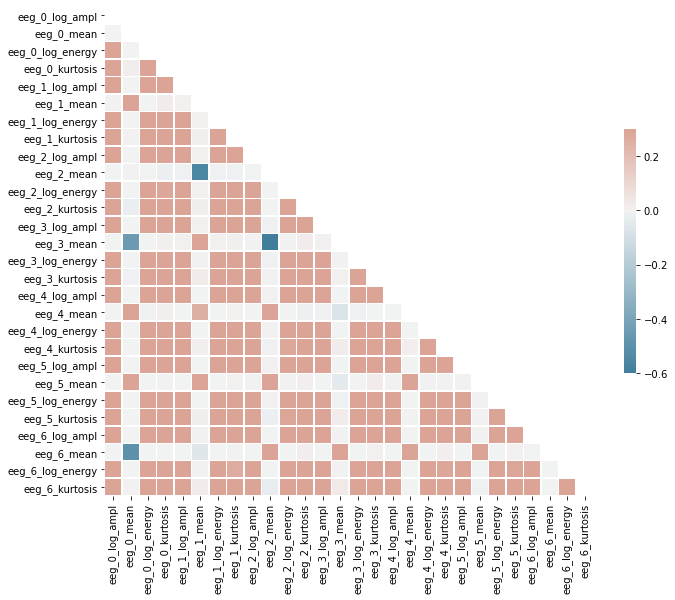

In [99]:
corr = features.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [108]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

X_train, X_test, y_train, y_test = train_test_split(features, y, test_size = 0.3)

slct = SelectKBest(f_classif, k=10)

X_train = slct.fit_transform(X_train, y_train)
X_test = slct.transform(X_test)

X_train

array([[ 4.96941996, 15.17842579,  5.75767136, ..., 15.24202442,
         5.7181797 , 15.83806229],
       [ 5.2612009 , 14.83462334,  4.75436974, ..., 28.00516129,
        11.4267807 , 28.00534058],
       [ 4.7137804 , 14.00213718,  6.67442799, ..., 14.0528574 ,
         6.67205381, 15.53963184],
       ...,
       [ 3.72618175, 12.14452171,  3.83839345, ..., 12.30428886,
         4.00612259, 12.61753368],
       [ 5.40622044, 14.34063339,  5.81883097, ..., 14.8905611 ,
         4.71391487, 14.07656193],
       [ 4.02346802, 12.93850708,  5.27421665, ..., 12.82048225,
         4.78584576, 14.0059576 ]])

In [109]:
clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None)
#clf = KNeighborsClassifier(n_neighbors = 15)
# clf= SVC(kernel = 'linear', C = 1)
# clf = GaussianNB()

clf.fit(X_train, y_train)

RandomForestClassifier()

In [110]:
predictions = clf.predict(X_test)
f1_score(predictions, y_test, average="weighted")

0.6450580026626953

In [111]:
predictions = clf.predict(X_train)
f1_score(predictions, y_train, average="weighted")

1.0

In [89]:
eval_path = "/home/benoit/data/dreem_challenge/X_test/X_test.h5"

d_eval = h5py.File(eval_path, 'r')

# features_eval['abs_index'] = sample
# features_eval.to_csv(join(data_dir, "computed", 'test_1_eval_a.csv'))

In [90]:
features_eval = load_features(join(data_dir, "computed", 'base_1_eval.csv'))
f_eval = features_eval.drop(['abs_index'], axis=1)

In [91]:
eval_pred = clf.predict(f_eval)

In [92]:
sub = read_csv(join(data_dir, 'sample_submission.csv'))
sub['sleep_stage'] = eval_pred

In [93]:
sub.to_csv("output/submission.csv", index=False)

In [94]:
sub

,index,sleep_stage
0,24688,4
1,24689,0
2,24690,0
3,24691,2
4,24692,3
...,...,...
24975,49663,2
24976,49664,2
24977,49665,2
24978,49666,4
